In [50]:
import pandas as pd
import numpy as np
import json
import glob
import tensorflow as tf
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [2]:
hrv_raw = pd.read_csv('./Fitbit/ShiYangLee/Sleep/daily_hrv_full.csv')
hrv_raw.head()

,timestamp,rmssd,nremhr,entropy
0,2022-02-27T00:00:00,52.053,53.789,2.833
1,2022-02-28T00:00:00,61.281,49.983,2.935
2,2022-03-01T00:00:00,59.392,50.798,2.943
3,2022-03-02T00:00:00,56.437,54.837,2.829
4,2022-03-03T00:00:00,54.982,52.368,2.927


In [3]:
hrv_raw.set_index('timestamp', inplace = True)

In [4]:
hrv_raw.index = pd.to_datetime(hrv_raw.index, format = '%Y-%m-%d')
# hrv_raw.index = hrv_raw.index.to_series().dt.strftime('%Y-%m-%d')

<AxesSubplot:xlabel='timestamp'>

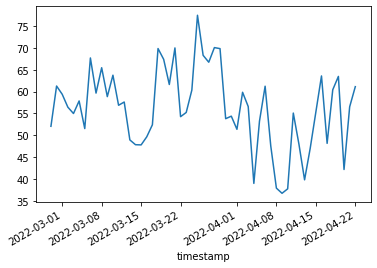

In [5]:
hrv_raw['rmssd'].plot()

In [6]:
hrv_raw['hrv_rolling'] = hrv_raw['rmssd'].rolling(7, 3, center = True).mean()

<AxesSubplot:xlabel='timestamp'>

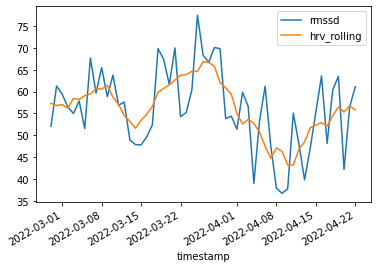

In [7]:
hrv_raw[['rmssd', 'hrv_rolling']].plot()

In [8]:
steps_raw = pd.read_csv('./Fitbit/ShiYangLee/Physical Activity/steps_full.csv')
steps_raw

,dateTime,value
0,2022-02-26 22:15:00,0
1,2022-02-26 22:16:00,5
2,2022-02-26 22:17:00,0
3,2022-02-26 22:18:00,0
4,2022-02-26 22:19:00,0
...,...,...
39856,2022-04-23 18:01:00,0
39857,2022-04-23 18:02:00,0
39858,2022-04-23 18:03:00,0
39859,2022-04-23 18:04:00,0


In [9]:
steps_raw.set_index('dateTime', inplace = True)
steps_raw.index = pd.to_datetime(steps_raw.index)
steps_per_day = steps_raw.groupby(steps_raw.index.to_series().dt.date).sum()
steps_per_day.index = pd.to_datetime(steps_per_day.index)
steps_per_day.columns = ['steps']

In [10]:
steps_per_day.head()

,steps
dateTime,
2022-02-26,60
2022-02-27,2542
2022-02-28,6426
2022-03-01,9602
2022-03-02,7721


In [11]:
hrv = hrv_raw.merge(steps_per_day, left_index=True, right_index=True)

In [12]:
hrv['steps_normalized'] = hrv['steps']/100
hrv['steps_rolling'] = hrv['steps_normalized'].rolling(7, 3, center = True).mean()

<AxesSubplot:>

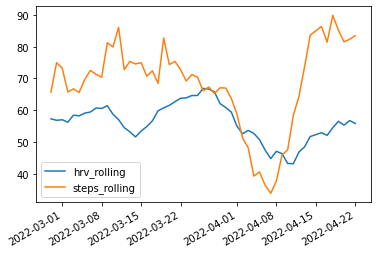

In [13]:
hrv[['hrv_rolling', 'steps_rolling']].plot()

In [14]:
sleep_dir = glob.glob('./Fitbit/ShiYangLee/Sleep/sleep-*.json')
dfs = []
for file in sleep_dir:
    data = pd.read_json(file)
    dfs.append(data)
sleep = pd.concat(dfs, ignore_index=True)
sleep.head()

,logId,dateOfSleep,startTime,endTime,duration,minutesToFallAsleep,minutesAsleep,minutesAwake,minutesAfterWakeup,timeInBed,efficiency,type,infoCode,levels,mainSleep
0,36625185402,2022-04-24,2022-04-23T22:20:30.000,2022-04-24T09:35:30.000,40500000,0,568,107,0,675,96,stages,0,"{'summary': {'deep': {'count': 5, 'minutes': 9...",True
1,36617451798,2022-04-23,2022-04-23T13:25:00.000,2022-04-23T14:56:00.000,5460000,0,80,11,0,91,88,classic,2,"{'summary': {'restless': {'count': 4, 'minutes...",False
2,36613912467,2022-04-23,2022-04-22T23:23:00.000,2022-04-23T11:20:30.000,43020000,0,623,94,0,717,93,stages,0,"{'summary': {'deep': {'count': 7, 'minutes': 1...",True
3,36600884643,2022-04-22,2022-04-21T23:13:00.000,2022-04-22T07:21:30.000,29280000,0,436,52,0,488,97,stages,0,"{'summary': {'deep': {'count': 1, 'minutes': 3...",True
4,36595887971,2022-04-21,2022-04-21T17:09:00.000,2022-04-21T18:34:00.000,5100000,0,82,3,0,85,96,classic,2,"{'summary': {'restless': {'count': 2, 'minutes...",False


In [15]:
json_struct = json.loads(sleep.to_json(orient='records'))
sleep = pd.json_normalize(json_struct)

In [16]:
sleep.drop(['levels.data', 'levels.shortData'], axis=1, inplace=True)
sleep

,logId,dateOfSleep,startTime,endTime,duration,minutesToFallAsleep,minutesAsleep,minutesAwake,minutesAfterWakeup,timeInBed,...,levels.summary.light.thirtyDayAvgMinutes,levels.summary.rem.count,levels.summary.rem.minutes,levels.summary.rem.thirtyDayAvgMinutes,levels.summary.restless.count,levels.summary.restless.minutes,levels.summary.awake.count,levels.summary.awake.minutes,levels.summary.asleep.count,levels.summary.asleep.minutes
0,36625185402,2022-04-24,2022-04-23T22:20:30.000,2022-04-24T09:35:30.000,40500000,0,568,107,0,675,...,271.0,14.0,143.0,101.0,NaN,NaN,NaN,NaN,NaN,NaN
1,36617451798,2022-04-23,2022-04-23T13:25:00.000,2022-04-23T14:56:00.000,5460000,0,80,11,0,91,...,NaN,NaN,NaN,NaN,4.0,10.0,1.0,1.0,0.0,80.0
2,36613912467,2022-04-23,2022-04-22T23:23:00.000,2022-04-23T11:20:30.000,43020000,0,623,94,0,717,...,269.0,12.0,153.0,99.0,NaN,NaN,NaN,NaN,NaN,NaN
3,36600884643,2022-04-22,2022-04-21T23:13:00.000,2022-04-22T07:21:30.000,29280000,0,436,52,0,488,...,267.0,6.0,95.0,99.0,NaN,NaN,NaN,NaN,NaN,NaN
4,36595887971,2022-04-21,2022-04-21T17:09:00.000,2022-04-21T18:34:00.000,5100000,0,82,3,0,85,...,NaN,NaN,NaN,NaN,2.0,3.0,0.0,0.0,0.0,82.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,35927511475,2022-03-02,2022-03-01T22:53:00.000,2022-03-02T05:49:30.000,24960000,0,394,22,0,416,...,195.0,4.0,112.0,65.0,NaN,NaN,NaN,NaN,NaN,NaN
69,35918720085,2022-03-01,2022-03-01T03:01:30.000,2022-03-01T09:26:00.000,23040000,0,321,63,0,384,...,199.0,6.0,58.0,68.0,NaN,NaN,NaN,NaN,NaN,NaN
70,35833591962,2022-02-28,2022-02-28T01:00:00.000,2022-02-28T07:15:58.000,22500000,27,328,48,0,375,...,205.0,5.0,74.0,62.0,NaN,NaN,NaN,NaN,NaN,NaN
71,35874554379,2022-02-27,2022-02-27T17:15:00.000,2022-02-27T18:25:00.000,4200000,26,41,3,0,70,...,NaN,NaN,NaN,NaN,7.0,21.0,6.0,8.0,0.0,41.0


In [17]:
sleep.to_csv('sleep_tmp.csv')

In [18]:
sleep = sleep[~sleep.duplicated(subset='logId', keep='last')]

In [19]:
sleep_duration_df = sleep.set_index('dateOfSleep')
sleep_duration_df.index = pd.to_datetime(sleep_duration_df.index)
print(sleep_duration_df.index.dtype)
sleep_duration_df = sleep_duration_df['minutesAsleep'].groupby(sleep_duration_df.index.to_series().dt.date).sum()

datetime64[ns]


In [20]:
sleep_duration_df.sort_index(inplace = True)

In [21]:
hrv = hrv.merge(sleep_duration_df, left_index=True, right_index=True)

In [22]:
hrv['minutesAsleep_normalized'] = hrv['minutesAsleep']/10
hrv['minutesAsleep_rolling'] = hrv['minutesAsleep_normalized'].rolling(7, 3, center=True)\
                                .mean()
hrv.head()

,rmssd,nremhr,entropy,hrv_rolling,steps,steps_normalized,steps_rolling,minutesAsleep,minutesAsleep_normalized,minutesAsleep_rolling
2022-02-27,52.053,53.789,2.833,57.290750,2542,25.42,65.727500,395,39.5,35.950000
2022-02-28,61.281,49.983,2.935,56.829000,6426,64.26,74.984000,328,32.8,34.500000
2022-03-01,59.392,50.798,2.943,57.001500,9602,96.02,73.248333,321,32.1,35.333333
2022-03-02,56.437,54.837,2.829,56.220143,7721,77.21,65.765714,394,39.4,38.057143
2022-03-03,54.982,52.368,2.927,58.457857,11201,112.01,66.738571,287,28.7,39.114286


<AxesSubplot:>

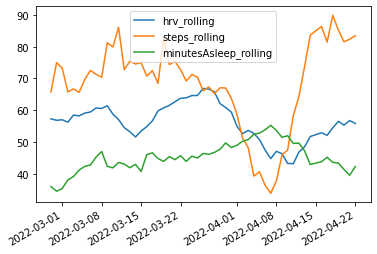

In [23]:
hrv[['hrv_rolling', 'steps_rolling', 'minutesAsleep_rolling']].plot()

In [24]:
def get_hrz_df():
    hrz_dir = glob.glob('./Fitbit/ShiYangLee/Physical Activity/time_in_heart_rate_zones-*.json')
    dfs = []
    for file in hrz_dir:
        tmp = pd.read_json(file, orient='values')
        dfs.append(tmp)
    hrz_df = pd.concat(dfs, ignore_index=True)
    hrz_df = pd.concat([hrz_df, pd.json_normalize(hrz_df['value'])], axis=1)
    hrz_df.drop('value', axis=1, inplace=True)
    hrz_df.set_index('dateTime', inplace=True)
    hrz_df.sort_index(inplace=True)
    hrz_df.rename(columns = {'valuesInZones.BELOW_DEFAULT_ZONE_1':'Resting_minutes', \
                             'valuesInZones.IN_DEFAULT_ZONE_1':'Fat_burn_minutes', \
                             'valuesInZones.IN_DEFAULT_ZONE_2':'Cardio_minutes', \
                             'valuesInZones.IN_DEFAULT_ZONE_3':'Peak_minutes'}, \
                  inplace=True)
    return hrz_df

In [25]:
hrz_df = get_hrz_df()
hrz_df.head()

,Cardio_minutes,Resting_minutes,Peak_minutes,Fat_burn_minutes
dateTime,,,,
2022-02-26,0.0,109.0,0.0,0.0
2022-02-27,2.0,1375.0,0.0,49.0
2022-02-28,1.0,1327.0,0.0,74.0
2022-03-01,2.0,1133.0,0.0,301.0
2022-03-02,0.0,1318.0,0.0,63.0


In [26]:
hrv = hrv.merge(hrz_df, left_index=True, right_index=True)

In [27]:
hrv.head()

,rmssd,nremhr,entropy,hrv_rolling,steps,steps_normalized,steps_rolling,minutesAsleep,minutesAsleep_normalized,minutesAsleep_rolling,Cardio_minutes,Resting_minutes,Peak_minutes,Fat_burn_minutes
2022-02-27,52.053,53.789,2.833,57.290750,2542,25.42,65.727500,395,39.5,35.950000,2.0,1375.0,0.0,49.0
2022-02-28,61.281,49.983,2.935,56.829000,6426,64.26,74.984000,328,32.8,34.500000,1.0,1327.0,0.0,74.0
2022-03-01,59.392,50.798,2.943,57.001500,9602,96.02,73.248333,321,32.1,35.333333,2.0,1133.0,0.0,301.0
2022-03-02,56.437,54.837,2.829,56.220143,7721,77.21,65.765714,394,39.4,38.057143,0.0,1318.0,0.0,63.0
2022-03-03,54.982,52.368,2.927,58.457857,11201,112.01,66.738571,287,28.7,39.114286,0.0,1261.0,0.0,134.0


In [28]:
lag_list = ['steps', 'minutesAsleep', 'Cardio_minutes', 'Resting_minutes', \
            'Peak_minutes', 'Fat_burn_minutes']
def get_lag(df, lag_list, num_lag = 10):
    for col in lag_list:
        df = df.join([df[col].shift(x).rename(f"{col}_lag{x}") \
                      for x in range(1, num_lag+1)])
    return df

In [69]:
test = get_lag(hrv, lag_list)
test.head()
test.to_csv('hrv_features_data.csv')

In [30]:
test.columns

Index(['rmssd', 'nremhr', 'entropy', 'hrv_rolling', 'steps',
       'steps_normalized', 'steps_rolling', 'minutesAsleep',
       'minutesAsleep_normalized', 'minutesAsleep_rolling', 'Cardio_minutes',
       'Resting_minutes', 'Peak_minutes', 'Fat_burn_minutes', 'steps_lag1',
       'steps_lag2', 'steps_lag3', 'steps_lag4', 'steps_lag5', 'steps_lag6',
       'steps_lag7', 'steps_lag8', 'steps_lag9', 'steps_lag10',
       'minutesAsleep_lag1', 'minutesAsleep_lag2', 'minutesAsleep_lag3',
       'minutesAsleep_lag4', 'minutesAsleep_lag5', 'minutesAsleep_lag6',
       'minutesAsleep_lag7', 'minutesAsleep_lag8', 'minutesAsleep_lag9',
       'minutesAsleep_lag10', 'Cardio_minutes_lag1', 'Cardio_minutes_lag2',
       'Cardio_minutes_lag3', 'Cardio_minutes_lag4', 'Cardio_minutes_lag5',
       'Cardio_minutes_lag6', 'Cardio_minutes_lag7', 'Cardio_minutes_lag8',
       'Cardio_minutes_lag9', 'Cardio_minutes_lag10', 'Resting_minutes_lag1',
       'Resting_minutes_lag2', 'Resting_minutes_lag3', 'Re

In [31]:
def get_partial_date(df, num):
    duration = df.index[-1] - df.index[0]
    return pd.to_datetime(df.index[0] + num * pd.to_timedelta(duration))

In [32]:
split_date = get_partial_date(test, 0.7)
train_df = test.drop(columns=['rmssd', 'nremhr', 'entropy', 'hrv_rolling', 'steps_normalized', \
                       'steps_rolling', 'minutesAsleep_normalized', 'minutesAsleep_rolling'])
train_df = train_df.interpolate(limit_direction='backward')
target_df = test['rmssd']

train_feature_df = train_df[train_df.index < split_date]
train_target_df = target_df[target_df.index < split_date]

test_feature_df = train_df[train_df.index >= split_date]
test_target_df = target_df[target_df.index >= split_date]

In [33]:
train_target_df.head()

2022-02-27    52.053
2022-02-28    61.281
2022-03-01    59.392
2022-03-02    56.437
2022-03-03    54.982
Name: rmssd, dtype: float64

In [34]:
model = LinearRegression(positive=True)
model.fit(X= train_feature_df, y = train_target_df)
test_pred = model.predict(test_feature_df)
train_pred = model.predict(train_feature_df)

In [35]:
if not isinstance(train_target_df, pd.DataFrame):
    train_target_df = train_target_df.to_frame()
if not isinstance(test_target_df,  pd.DataFrame):
    test_target_df = test_target_df.to_frame()
train_target_df['pred'] = train_pred
test_target_df['pred'] = test_pred
final_df = pd.concat([train_target_df, test_target_df])

In [36]:
model.score(test_feature_df, test_target_df['rmssd'])

-2.4953216606432194

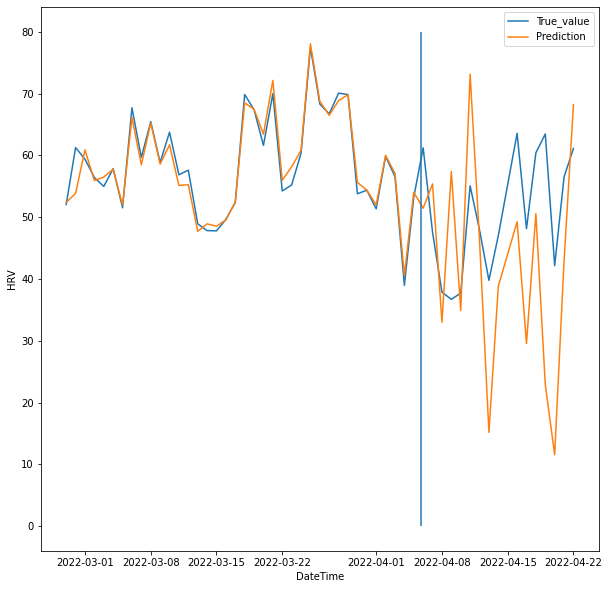

In [74]:
plt.rcParams["figure.figsize"] = (10, 10)
plt.plot(final_df, label = ['True_value','Prediction'])
plt.xlabel('DateTime')
plt.ylabel('HRV')
plt.vlines(split_date, ymin=0, ymax=80)
plt.legend()
plt.savefig('HRV_prediction.jpeg')
plt.show()

In [64]:
pd.set_option('display.max_rows', 10)
coef = pd.DataFrame(zip(train_feature_df.columns, model.coef_), columns = ['variables', 'coefficients'])
coef = coef.sort_values('coefficients', ascending=False)
coef.head(10)

,variables,coefficients
49,Peak_minutes_lag4,4.295120
53,Peak_minutes_lag8,2.858245
52,Peak_minutes_lag7,2.161355
54,Peak_minutes_lag9,0.893000
2,Cardio_minutes,0.798600
50,Peak_minutes_lag5,0.624255
51,Peak_minutes_lag6,0.612568
34,Cardio_minutes_lag9,0.514927
33,Cardio_minutes_lag8,0.191011
60,Fat_burn_minutes_lag5,0.181967


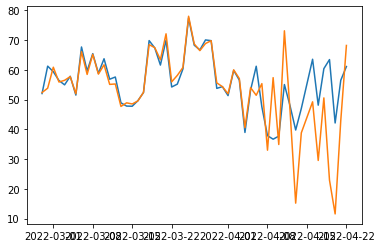

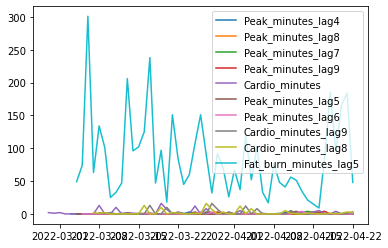

In [68]:
plt.figure(1)
plt.plot(final_df, label = ['True_value','Prediction'])
plt.figure(2)
plt.plot(test[coef['variables'][:10]], label = coef['variables'][:10])
plt.legend()
plt.show()

In [ ]:
x

In [ ]:
def get_partial_date(df, num):
    duration = df.index[-1] - df.index[0]
    return pd.to_datetime(df.index[0] + num * pd.to_timedelta(duration))

In [ ]:
y = get_partial_date(test, 0.3)
y

In [ ]:
type(y)

In [ ]:
asd = test.loc[test.index < y]

In [ ]:
asd